# Wasserstein Metric

This notebook uses the Wasserstein metric to recluster the clients of Alliander based on their pairwise distances

Import all packages and load all data. This cell might take a few minutes

In [1]:
# standard imports
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import the metric
from scipy.stats import wasserstein_distance

# import clustering algorithm
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import sklearn as skl

# import machine learning algorithms for predicting
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# import custom Alliander data
from load_data_scripts import load_save_profiles
from load_data_scripts import save_unique_profile_customer

# load customer usage - now only select first 1200 customers, 1000 for training, 200 for testing
customers = save_unique_profile_customer.unique_customer(nrows=1200)

# load connections
connection, Alliander_profiles = load_save_profiles.load_profiles()

# select last month for testing
customers = customers[customers.columns[-2880:]]
date_num = customers.shape[1]

# divide customers into train and test set
customers_test = customers.iloc[1000:]
customers = customers.iloc[:1000]

customer_num = len(customers.index)
date_num = customers.shape[1]

Create the "blind data", i.e. the (monthly) mean usage and maximal usage. This will be used late on to cluster the data and see if we can propperly predict the data usage of a customer provided their total and maximal usage. Note that "total" and "mean" usage analytically can be arbitrarily used. However, when computationally finding optima/minima, it is more convenient to have the variables to be within the same order size.

In [2]:
profile_type = connection.loc[customers.index, 'BASELOAD_PROFILE']

profile_map = dict(zip(list(connection['BASELOAD_PROFILE'].unique()),
                   range(len(connection['BASELOAD_PROFILE'].unique()))))

data_dict = {"total_usage": customers.mean(axis=1),
            "maximal_usage": customers.max(axis=1),
            "profile": profile_type}

avg_max_customers = pd.DataFrame(data=data_dict, index=customers.index)
avg_max_customers.profile.replace(profile_map, inplace=True)


# Now do the same for the test:
profile_type_test = connection.loc[customers_test.index, 'BASELOAD_PROFILE']

test_data_dict = {"total_usage": customers_test.mean(axis=1),
                  "maximal_usage": customers_test.max(axis=1),
                  "profile": profile_type_test}

avg_max_customers_test = pd.DataFrame(data=test_data_dict, index=customers_test.index)
avg_max_customers_test.profile.replace(profile_map, inplace=True)

# Compute pairwise distance w.r.t. metric
Create a baseline/example customer to compare all other customers to.
The chosen baseline is a weekly oscillation of which we suspect most customers have some similarity to.

In [3]:

# there are 672 points of 15 min intervals in a week
weekly_oscillation = ((-1*np.cos(np.arange(date_num)/672*np.pi*2)+1))
weekly_oscillation = weekly_oscillation/np.sum(weekly_oscillation)
weekly_df = pd.DataFrame(weekly_oscillation,
                         index=customers.columns)

# monthly_oscillation = (-1*np.cos(np.arange(date_num)/2880*np.pi*2)+1)
# montly_oscillation = monthly_oscillation/np.sum(monthly_oscillation)
# monthly_df = pd.DataFrame(monthly_oscillation,
#                           index=customers.columns)

Calculate the wasserstein between customers and chosen baseline. It's not strange if this cell takes 20 minutes to compute. Note that this part can be changed such that the whole program would also work for different kinds of metrics.

In [4]:
wass_weekly_dist = customers.apply(lambda x:
                                   wasserstein_distance((x.values)/x.sum(),
                                                        weekly_oscillation),
                                   axis=1)

# wass_monthly_dist = customers.apply(lambda x:
#                                     wasserstein_distance((x.values)/x.sum(),
#                                                          monthly_oscillation),
#                                     axis=1)

Show some stats of the newly computed wasserstein distance. We only show 99th quantile since the metric has large outliers.

min, max values are:  0.10081798574378281   81.30416682384241
now removing the upper quantile:
 new min, max values are:  0.10081798574378281   1.5622135579427994
wass_dist head: 
2.0    0.382225
3.0    0.308600
4.0    0.456452
5.0    0.384637
6.0    0.233519
dtype: float64


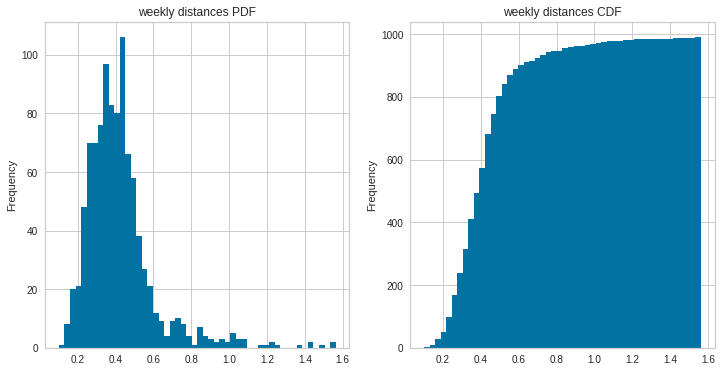

In [5]:
wass_weekly_dist = wass_weekly_dist*date_num
print('min, max values are: ', wass_weekly_dist.min(), ' ',
      wass_weekly_dist.max())

print('now removing the upper quantile:')
q = wass_weekly_dist.quantile(0.99)
wass_weekly_dist_plot = wass_weekly_dist[wass_weekly_dist < q]

print(' new min, max values are: ', wass_weekly_dist_plot.min(), ' ',
      wass_weekly_dist_plot.max())
print('wass_dist head: ')
print(wass_weekly_dist_plot.head())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
wass_weekly_dist_plot.plot.hist(ax=axes[0], bins=50, title='weekly distances PDF')
wass_weekly_dist_plot.plot.hist(ax=axes[1], cumulative=True, bins=50, title='weekly distances CDF')


plt.show()

Now here we will use inversion/quantiles on the CDF to provides weights for the customers and find all neighbours within those intervals

histogram of neighbours for customers: 
[205, 249, 253, 215, 206, 222, 78, 133, 235, 191, 213, 251, 223, 133, 219, 212, 230, 247, 254, 244]


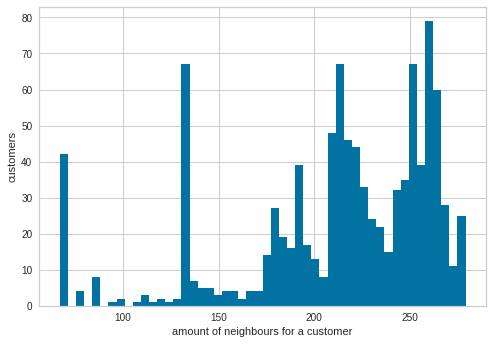

In [18]:
sort_wass_week = np.sort(wass_weekly_dist)

wass_sort_df = pd.DataFrame(wass_weekly_dist, columns=["wassDist"]).sort_values(by="wassDist")
wass_sort_df.index.name = "customer"
wass_sort_df.index = pd.Index(wass_sort_df.index, dtype='int')
wass_sort_df['weight'] = pd.qcut(sort_wass_week, q=15)
wass_sort_df['weight'] = wass_sort_df['weight'].apply(lambda x: x.length)

wass_sort_df['neighbours'] = wass_sort_df.wassDist.apply(lambda x: wass_sort_df.index[
    [math.isclose(y['wassDist'], x, abs_tol=y['weight']) for _, y in wass_sort_df.iterrows()]])

wass_sort_df = wass_sort_df.sort_values(by="customer")

print("histogram of neighbours for customers: ")
plotje = []
for i in wass_sort_df['neighbours']:
    plotje.append(len(i))
    
print(plotje[0:20])
plt.hist(plotje, bins=50)
plt.xlabel("amount of neighbours for a customer")
plt.ylabel("customers")
plt.show()

Actually fill the distance matrix. Note that it takes roughly 0.2 seconds to calculate the wasserstein distance between two customers, and the customers are highly clustered: most customers have more than 800 potential neighbours.

In [7]:
# create a map to remember all indices
cust_to_index_dict = dict(zip(wass_sort_df.index, range(len(wass_sort_df.index))))
# print(cust_to_index_dict)
                          
print("start dist matrix: ")
dist_mat = np.ones((len(wass_sort_df.index), len(wass_sort_df.index)))*math.inf

verbose = False

visit_list = set()
fivehundredcount = 500
small_count = 0
for index, row in wass_sort_df.iterrows():
    for neighbour in row["neighbours"]:
        if neighbour < index:
            continue
            
        distance = wasserstein_distance(customers.loc[index], customers.loc[neighbour])
        dist_mat[cust_to_index_dict[index]][cust_to_index_dict[neighbour]] = distance
        dist_mat[cust_to_index_dict[neighbour]][cust_to_index_dict[index]] = distance
        visit_list.update((index, neighbour))
        
        if verbose:
            if len(visit_list) % 500 == 0:
                print(len(visit_list), " at index: ", index)
            if len(visit_list) > 3500:
                if index > small_count:
                    print("now at index: ", index)
                    small_count += 100
    if verbose:
        if index / fivehundredcount > 1:
            fivehundredcount += 500
            print("now at index ", index)

print(wass_sort_df)
# print(dist_mat[0:20][0:20])

start dist matrix: 
500  at index:  4
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
1000  at index:  56
10

1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59
1000  at index:  59


1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  62
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63
1000  at index:  63


1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66
1000  at index:  66


1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68
1000  at index:  68


1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71
1000  at index:  71


1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75
1000  at index:  75


1000  at index:  77
1000  at index:  77
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78
1000  at index:  78


1000  at index:  81
1000  at index:  81
1000  at index:  81
1000  at index:  81
1000  at index:  81
1000  at index:  81
1000  at index:  81
1000  at index:  81
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82
1000  at index:  82


1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85
1000  at index:  85


1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87
1000  at index:  87


1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89
1000  at index:  89


1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94
1000  at index:  94


1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  95
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96
1000  at index:  96


1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99
1000  at index:  99


1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at index:  101
1000  at inde

1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at index:  105
1000  at inde

1000  at index:  112
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at index:  113
1000  at inde

1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at index:  115
1000  at inde

1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at index:  118
1000  at inde

1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  121
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at index:  123
1000  at inde

1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  125
1000  at index:  126
1000  at index:  126
1000  at index:  126
1000  at index:  126
1000  at index:  126
1000  at inde

1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  128
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at index:  129
1000  at inde

1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at index:  132
1000  at inde

1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  134
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at index:  136
1000  at inde

1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at index:  139
1000  at inde

1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  141
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at index:  142
1000  at inde

1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at index:  145
1000  at inde

1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at index:  147
1000  at inde

1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at index:  153
1000  at inde

1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at index:  155
1000  at inde

1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at index:  159
1000  at inde

1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at index:  163
1000  at inde

1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  166
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at index:  168
1000  at inde

1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  170
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at index:  171
1000  at inde

1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at index:  175
1000  at inde

1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  177
1000  at index:  178
1000  at index:  178
1000  at index:  178
1000  at index:  178
1000  at index:  178
1000  at index:  178
1000  at index:  178
1000  at index:  178
1000  at index:  178
1000  at index:  178
1000  at index:  178
1000  at inde

1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at index:  179
1000  at inde

1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at index:  183
1000  at inde

1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at index:  187
1000  at inde

1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at index:  190
1000  at inde

1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at index:  194
1000  at inde

1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at index:  198
1000  at inde

1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at index:  202
1000  at inde

1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  206
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at index:  207
1000  at inde

1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at index:  211
1000  at inde

1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at index:  218
1000  at inde

1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  220
1000  at index:  221
1000  at index:  221
1000  at index:  221
1000  at index:  221
1000  at inde

1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at index:  224
1000  at inde

1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at index:  227
1000  at inde

1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at index:  232
1000  at inde

1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at index:  236
1000  at inde

1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at index:  239
1000  at inde

1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at index:  245
1000  at inde

1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at index:  248
1000  at inde

1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at index:  252
1000  at inde

1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  255
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at index:  256
1000  at inde

1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at index:  259
1000  at inde

1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  264
1000  at index:  265
1000  at index:  265
1000  at index:  265
1000  at inde

1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at index:  267
1000  at inde

1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at index:  271
1000  at inde

1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at index:  273
1000  at inde

1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at index:  277
1000  at inde

1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at index:  283
1000  at inde

1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at index:  285
1000  at inde

1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at index:  288
1000  at inde

1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at index:  294
1000  at inde

1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at index:  297
1000  at inde

1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at index:  300
1000  at inde

1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at index:  306
1000  at inde

1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at index:  309
1000  at inde

1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  311
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at index:  312
1000  at inde

1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  314
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at index:  315
1000  at inde

1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at index:  321
1000  at inde

1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at index:  327
1000  at inde

1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at index:  332
1000  at inde

1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at index:  335
1000  at inde

1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at index:  340
1000  at inde

1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  343
1000  at index:  345
1000  at index:  345
1000  at index:  345
1000  at index:  345
1000  at index:  345
1000  at index:  345
1000  at index:  345
1000  at index:  345
1000  at inde

1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  347
1000  at index:  349
1000  at index:  349
1000  at inde

1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  351
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at index:  352
1000  at inde

1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at index:  356
1000  at inde

1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at index:  362
1000  at inde

1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at index:  366
1000  at inde

1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at index:  369
1000  at inde

1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at index:  372
1000  at inde

1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at index:  376
1000  at inde

1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at index:  381
1000  at inde

1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  384
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at index:  385
1000  at inde

1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at index:  388
1000  at inde

1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at index:  392
1000  at inde

1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  397
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at index:  398
1000  at inde

1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at index:  402
1000  at inde

1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  405
1000  at index:  406
1000  at index:  406
1000  at index:  406
1000  at index:  406
1000  at index:  406
1000  at inde

1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at index:  410
1000  at inde

1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at index:  412
1000  at inde

1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at index:  415
1000  at inde

1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at index:  418
1000  at inde

1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  421
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at index:  423
1000  at inde

1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at index:  427
1000  at inde

1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at index:  432
1000  at inde

1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at index:  436
1000  at inde

1000  at index:  438
1000  at index:  438
1000  at index:  438
1000  at index:  438
1000  at index:  438
1000  at index:  438
1000  at index:  438
1000  at index:  438
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at index:  439
1000  at inde

1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at index:  442
1000  at inde

1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at index:  448
1000  at inde

1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at index:  451
1000  at inde

1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at index:  453
1000  at inde

1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  457
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at index:  458
1000  at inde

1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at index:  461
1000  at inde

1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at index:  466
1000  at inde

1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at index:  471
1000  at inde

1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  474
1000  at index:  475
1000  at index:  475
1000  at index:  475
1000  at index:  475
1000  at index:  475
1000  at index:  475
1000  at index:  475
1000  at inde

1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at index:  482
1000  at inde

1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  486
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at index:  487
1000  at inde

1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  489
1000  at index:  490
1000  at index:  490
1000  at inde

1000  at index:  493
1000  at index:  493
1000  at index:  493
1000  at index:  493
1000  at index:  493
1000  at index:  493
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at index:  494
1000  at inde

1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at index:  497
1000  at inde

1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  499
1000  at index:  500
1000  at index:  500
1000  at inde

1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at index:  503
1000  at inde

1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at index:  510
1000  at inde

1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at index:  513
1000  at inde

1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at index:  518
1000  at inde

1000  at index:  522
1000  at index:  522
1000  at index:  522
1000  at index:  522
1000  at index:  522
1000  at index:  522
1000  at index:  522
1000  at index:  522
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at index:  523
1000  at inde

1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  526
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at index:  527
1000  at inde

1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at index:  533
1000  at inde

1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at index:  538
1000  at inde

1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at index:  545
1000  at inde

1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  549
1000  at index:  554
1000  at inde

1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at index:  558
1000  at inde

1000  at index:  561
1000  at index:  561
1000  at index:  561
1000  at index:  561
1000  at index:  561
1000  at index:  561
1000  at index:  561
1000  at index:  561
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at index:  562
1000  at inde

1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  566
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at index:  567
1000  at inde

1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  571
1000  at index:  572
1000  at index:  572
1000  at index:  572
1000  at inde

1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at index:  578
1000  at inde

1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at index:  584
1000  at inde

1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at index:  590
1000  at inde

1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at index:  598
1000  at inde

1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at index:  605
1000  at inde

1000  at index:  611
1000  at index:  611
1000  at index:  611
1000  at index:  611
1000  at index:  611
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at index:  613
1000  at inde

1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at index:  618
1000  at inde

1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  622
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at index:  624
1000  at inde

1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  627
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at index:  628
1000  at inde

1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at index:  634
1000  at inde

1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at index:  640
1000  at inde

1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at index:  648
1000  at inde

1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at index:  654
1000  at inde

1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at index:  661
1000  at inde

1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  669
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at index:  671
1000  at inde

1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at index:  675
1000  at inde

1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  682
1000  at index:  683
1000  at index:  683
1000  at index:  683
1000  at index:  683
1000  at index:  683
1000  at index:  683
1000  at index:  683
1000  at index:  683
1000  at index:  683
1000  at index:  683
1000  at inde

1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at index:  687
1000  at inde

1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  693
1000  at index:  694
1000  at index:  694
1000  at index:  694
1000  at index:  694
1000  at index:  694
1000  at index:  694
1000  at index:  694
1000  at index:  694
1000  at inde

1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at index:  700
1000  at inde

1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at index:  707
1000  at inde

1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  713
1000  at index:  714
1000  at index:  714
1000  at index:  714
1000  at inde

1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  719
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at index:  720
1000  at inde

1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  725
1000  at index:  727
1000  at index:  727
1000  at index:  727
1000  at index:  727
1000  at index:  727
1000  at index:  727
1000  at index:  727
1000  at index:  727
1000  at inde

1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at index:  730
1000  at inde

1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at index:  737
1000  at inde

1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at index:  744
1000  at inde

1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at index:  750
1000  at inde

1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at index:  757
1000  at inde

1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at index:  769
1000  at inde

1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at index:  774
1000  at inde

1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at index:  781
1000  at inde

1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  790
1000  at index:  791
1000  at index:  791
1000  at index:  791
1000  at index:  791
1000  at inde

1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at index:  799
1000  at inde

1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  809
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at index:  810
1000  at inde

1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  816
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at index:  817
1000  at inde

1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  823
1000  at index:  824
1000  at index:  824
1000  at index:  824
1000  at index:  824
1000  at index:  824
1000  at index:  824
1000  at inde

1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at index:  832
1000  at inde

1000  at index:  838
1000  at index:  838
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at index:  839
1000  at inde

1000  at index:  848
1000  at index:  848
1000  at index:  848
1000  at index:  848
1000  at index:  848
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at index:  849
1000  at inde

1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  854
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at index:  855
1000  at inde

1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at index:  865
1000  at inde

1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  874
1000  at index:  875
1000  at index:  875
1000  at index:  875
1000  at index:  875
1000  at index:  875
1000  at index:  875
1000  at index:  875
1000  at index:  875
1000  at inde

1000  at index:  881
1000  at index:  881
1000  at index:  881
1000  at index:  881
1000  at index:  881
1000  at index:  881
1000  at index:  881
1000  at index:  881
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at index:  883
1000  at inde

1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  891
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at index:  893
1000  at inde

1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  902
1000  at index:  903
1000  at index:  903
1000  at index:  903
1000  at index:  903
1000  at index:  903
1000  at index:  903
1000  at index:  903
1000  at inde

1000  at index:  908
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at index:  910
1000  at inde

1000  at index:  917
1000  at index:  917
1000  at index:  917
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at index:  918
1000  at inde

1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  928
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at index:  930
1000  at inde

1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at index:  940
1000  at inde

1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  948
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  949
1000  at index:  951
1000  at index:  951
1000  at index:  951
1000  at index:  951
1000  at index:  951
1000  at index:  951
1000  at inde

1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  958
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at index:  961
1000  at inde

1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  973
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at index:  977
1000  at inde

1000  at index:  988
1000  at index:  988
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at index:  991
1000  at inde

1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1003
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at index:  1004
1000  at i

1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at index:  1015
1000  at i

1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1025
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at index:  1028
1000  at i

1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1037
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at index:  1038
1000  at i

1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1048
1000  at index:  1049
1000  at index:  1049
1000  at index:  1049
1000  at index:  1049
1000  at i

1000  at index:  1057
1000  at index:  1057
1000  at index:  1057
1000  at index:  1057
1000  at index:  1057
1000  at index:  1057
1000  at index:  1057
1000  at index:  1057
1000  at index:  1057
1000  at index:  1057
1000  at index:  1057
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at index:  1058
1000  at i

1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1073
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at index:  1074
1000  at i

1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1090
1000  at index:  1091
1000  at index:  1091
1000  at index:  1091
1000  at index:  1091
1000  at index:  1091
1000  at index:  1091
1000  at index:  1091
1000  at index:  1091
1000  at i

1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1104
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at index:  1105
1000  at i

1000  at index:  1116
1000  at index:  1116
1000  at index:  1116
1000  at index:  1116
1000  at index:  1116
1000  at index:  1116
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at index:  1117
1000  at i

1000  at index:  1135
1000  at index:  1135
1000  at index:  1135
1000  at index:  1135
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1136
1000  at index:  1137
1000  at index:  1137
1000  at index:  1137
1000  at index:  1137
1000  at index:  1137
1000  at index:  1137
1000  at index:  1137
1000  at index:  1137
1000  at index:  1137
1000  at index:  1137
1000  at index:  1137
1000  at i

1000  at index:  1158
1000  at index:  1158
1000  at index:  1158
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1159
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at index:  1161
1000  at i

1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1197
1000  at index:  1198
1000  at index:  1198
1000  at index:  1198
1000  at index:  1198
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at index:  1199
1000  at i

1000  at index:  1234
1000  at index:  1234
1000  at index:  1234
1000  at index:  1234
1000  at index:  1234
1000  at index:  1234
1000  at index:  1234
1000  at index:  1234
1000  at index:  1235
1000  at index:  1235
1000  at index:  1235
1000  at index:  1235
1000  at index:  1235
1000  at index:  1235
1000  at index:  1235
1000  at index:  1235
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1237
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1238
1000  at index:  1239
1000  at index:  1239
1000  at index:  1239
1000  at i

# Create new clustering for customers

Here we cluster the customers in the distance matrix. Note that even though KMeans indicates that the data can be clustered well; this is only by construnctio due to the solve of neighbours to decrease algorithm complexity.

Centroids of the clusters: 
[[ 43.02439614 469.45138889 469.45138889 ... 469.45138889 469.45138889
   70.93870773]
 [469.45138889 131.46588753 469.45138889 ... 469.45138889 469.45138889
  469.45138889]
 [469.45138889 469.45138889  77.573213   ... 469.45138889 469.45138889
  469.45138889]
 ...
 [469.45138889  36.03762153 469.45138889 ... 154.24271419  88.63625337
  469.45138889]
 [332.23592593 469.45138889 469.45138889 ... 469.45138889 469.45138889
   19.64966049]
 [469.45138889 243.93440171 469.45138889 ... 469.45138889 469.45138889
  469.45138889]]
Silhouetter Score: 0.232


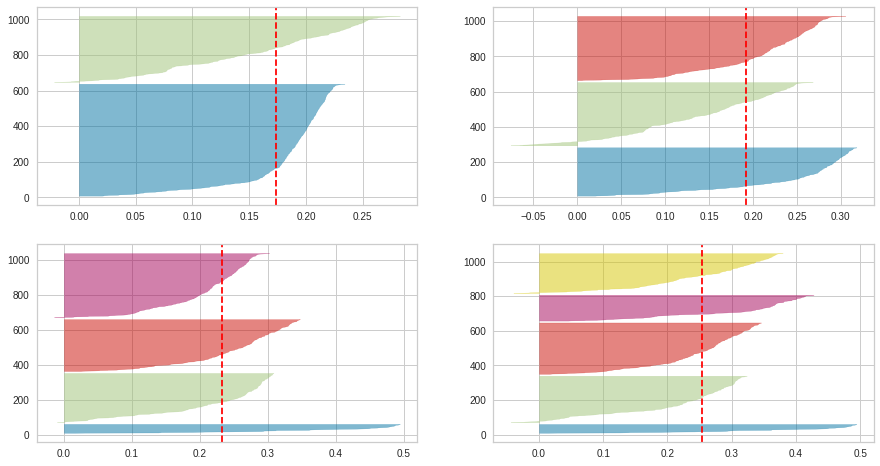

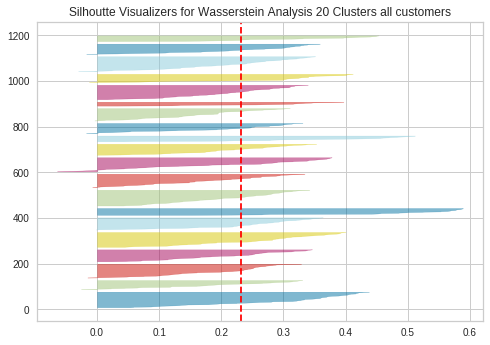

In [8]:
# now only work with new_dist_mat!!
new_dist_mat = dist_mat


max_val = np.amax(np.where(np.isinf(new_dist_mat), 0, new_dist_mat)) 
new_dist_mat = np.nan_to_num(dist_mat, posinf= max_val)

X = new_dist_mat

# Now apply KMeans
# Instantiate the KMeans models
#
km = KMeans(n_clusters=20, random_state=42)
#
# Fit the KMeans model
#
km.fit_predict(X)
centroids = km.cluster_centers_
print('Centroids of the clusters: ')
print(centroids)

#
# Calculate Silhoutte Score
#
score = skl.metrics.silhouette_score(X, km.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)



# fig, ax = plt.subplots(2, 2, figsize=(15,8))

# for i in [2, 3, 4, 5]:
#     '''
#     Create KMeans instance for different number of clusters
#     '''
#     km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
#     q, mod = divmod(i, 2)
#     '''
#     Create SilhouetteVisualizer instance with KMeans instance
#     Fit the visualizer
#     '''
#     visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
#     visualizer.fit(X)


plt.show()


km = KMeans(n_clusters=20, init='k-means++', n_init=10, max_iter=100, random_state=42)

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(X)

plt.title('Silhoutte Visualizers for Wasserstein Analysis 20 Clusters all customers')
plt.show()


kmeans = KMeans(n_clusters=20, init = 'k-means++', n_init = 10, max_iter = 100, random_state=42).fit(X)

# print(kmeans.labels_)
labels = kmeans.labels_
# print(kmeans.cluster_centers_)


# Gaussian Process Classifier for predicting next customer

In [9]:
prev_KMeans = KMeans

# X = new_dist_mat
X = avg_max_customers
y = kmeans.labels_
gpc = GaussianProcessClassifier(#kernel=kernel,
        random_state=0).fit(X, y)
gpc_score = gpc.score(X, y)


In [10]:
print(gpc_score)
print()

# print(gpc.predict_proba(X[['total_usage', 'maximal_usage']][:2]))
# print(y[:2])
print(X)
customers['labels'] = labels
X['labels'] = labels
print("labels: ", customers['labels'])

0.972

        total_usage  maximal_usage  profile
2.0       10.218056           36.0        2
3.0       54.865276          144.0        3
4.0      103.973610          516.0        4
5.0       13.259722           48.0        3
6.0       29.981945           88.0        5
...             ...            ...      ...
1299.0     5.134722           12.0       10
1300.0    25.769444           80.0       12
1303.0     2.452778           24.0       19
1305.0   110.595833          240.0       19
1306.0    24.880556           60.0       18

[1000 rows x 3 columns]
labels:  2.0        0
3.0       17
4.0       13
5.0        0
6.0       19
          ..
1299.0    15
1300.0    16
1303.0    10
1305.0    10
1306.0    18
Name: labels, Length: 1000, dtype: int32


# Reclustering new profiles

Customers are being clustered according to their relative wasserstein distance. After we will see if these new clusterrs describe and predict new customers better than the current method from Alliander

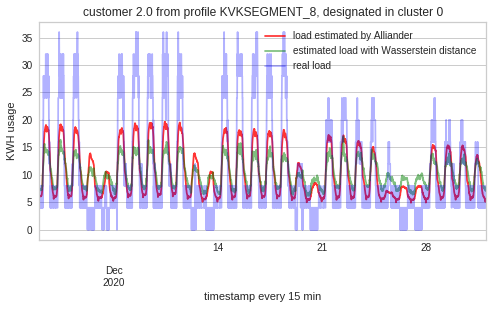

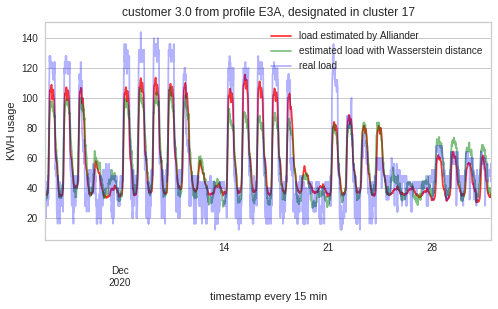

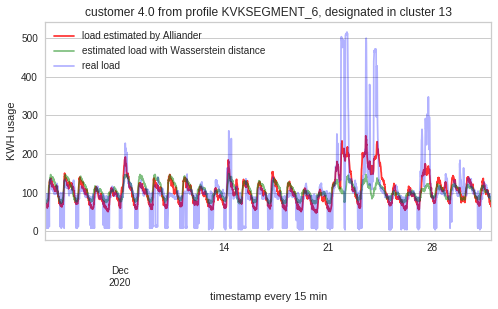

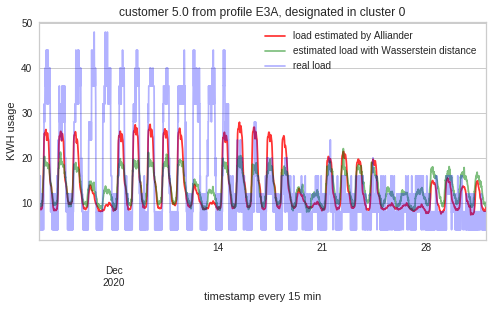

In [11]:
# get Alliander profile data that coinsides on dates preselected from customers
times = list(customers.columns)[:-1]
Alliander_profiles = Alliander_profiles.loc[times]


# create profiles based on wasserstein/KMeans clustering
profile_dict_data = {}
for i in range(20):
    profile_dict_data.update({str(i): customers.loc[customers['labels'] == i].sum()})

new_profiles = pd.DataFrame(data = profile_dict_data,
                            index = customers.columns)
new_profiles.drop(new_profiles.tail(1).index,inplace=True) 
new_profiles.index = pd.to_datetime(new_profiles.index)

# normalize new profiles
new_profiles = new_profiles/new_profiles.sum()

for customer_id in customers.index:
    if customer_id > 5:
        break

    # get estimated profiles
    profile_type = connection.loc[customer_id, 'BASELOAD_PROFILE']
    Alliander_profile_customer = Alliander_profiles[profile_type] / Alliander_profiles[profile_type].sum()
    
    wass_type = X['labels'].loc[customer_id]
    wass_profile_customer = new_profiles[str(wass_type)]
    
    # profile and profile esitmates
    customer = customers.loc[customer_id].drop('labels')
    SJV = customer.sum()
    customer.index = pd.to_datetime(customer.index)
    est_Alliander_load = SJV*Alliander_profile_customer
    est_wass_load = SJV*wass_profile_customer
    
    
    plt.figure(figsize=(8, 4))
    plt.xlabel('timestamp every 15 min')
    plt.ylabel('KWH usage')

    plt.title("customer {} from profile {}, designated in cluster {}".format(
        customer_id, profile_type, wass_type))
    ax1 = est_Alliander_load.plot.line(color='red', grid=True,
                                 label="load estimated by Alliander",
                                 alpha=0.8)
    ax2 = est_wass_load.plot.line(color='green', grid=True,
                                 label="estimated load with Wasserstein distance",
                                 alpha=0.5)
    ax3 = customer.plot.line(color='blue', grid=True,
                             label="real load",
                             alpha=0.3)
    
    plt.legend()
    plt.show()
    
# print(sub_Alliander.index)
# print(customers.columns)

# Testing standard error against Allainder

Here I want to showcase the standard error the new Wasserstein clustering has compared to the Alliander clustering

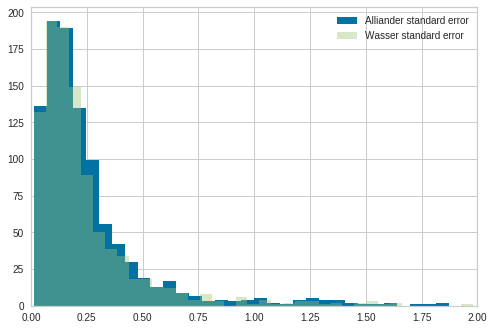

In [12]:
Alliander_error = []
Wasser_error = []

for customer_id in customers.index:
    
    profile_type = connection.loc[customer_id, 'BASELOAD_PROFILE']
    Alliander_profile_customer = Alliander_profiles[profile_type] / Alliander_profiles[profile_type].sum()
    
    wass_type = X['labels'].loc[customer_id]
    wass_profile_customer = new_profiles[str(wass_type)]
    
    # profile and profile esitmates
    customer = customers.loc[customer_id].drop('labels')
    SJV = customer.sum()
    customer.index = pd.to_datetime(customer.index)
    est_Alliander_load = SJV*Alliander_profile_customer
    est_wass_load = SJV*wass_profile_customer
    
    Alliander_error.append((est_Alliander_load - customer).sem())
    Wasser_error.append((est_wass_load-customer).sem())
    
plt.xlim(0,2)
plt.hist(Alliander_error, bins=100, label="Alliander standard error")
plt.hist(Wasser_error, bins=100, label="Wasser standard error", alpha=0.4)
plt.legend()
plt.show()

# Does predicting the next customer with the Wasserstein improve the prediction compared to the current Allainder model?

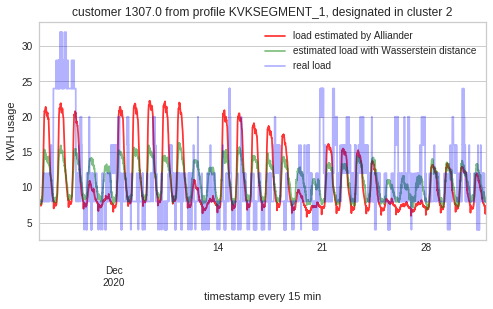

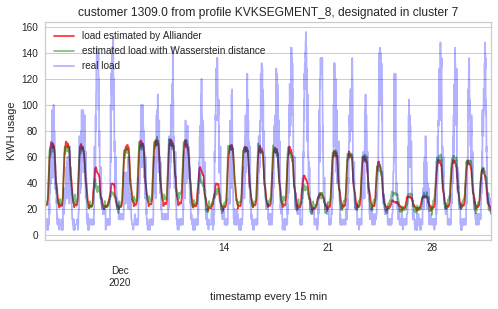

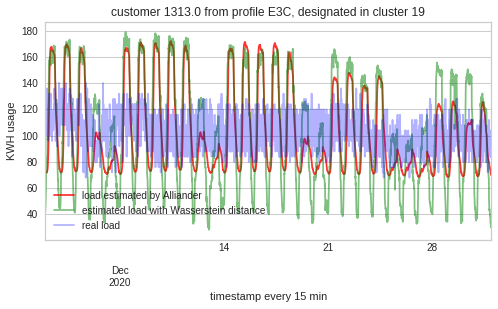

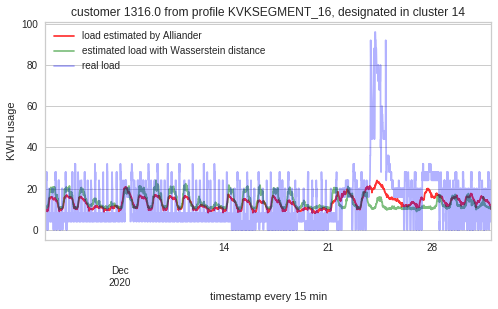

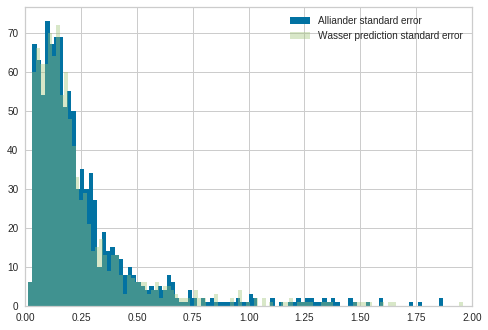

In [13]:
predictions = gpc.predict(avg_max_customers_test)

customers_test['labels'] = predictions

# get Alliander profile data that coinsides on dates preselected from customers
times = list(customers.columns)[:-1]
Alliander_profiles = Alliander_profiles.loc[times]

Alliander_test_error = []
Wasser_test_error = []

count = 0
for customer_id in customers_test.index:

    # get estimated profiles
    profile_type = connection.loc[customer_id, 'BASELOAD_PROFILE']
    Alliander_profile_customer = Alliander_profiles[profile_type] / Alliander_profiles[profile_type].sum()
    
    wass_type = customers_test['labels'].loc[customer_id]
    wass_profile_customer = new_profiles[str(wass_type)]
    
    # profile and profile esitmates
    customer = customers_test.loc[customer_id].drop('labels')
    SJV = customer.sum()
    customer.index = pd.to_datetime(customer.index)
    est_Alliander_load = SJV*Alliander_profile_customer
    est_wass_load = SJV*wass_profile_customer
    
    Alliander_test_error.append((est_Alliander_load - customer).sem())
    Wasser_test_error.append((est_wass_load-customer).sem())
    
    
    # plot first 4 fits for illustration
    if count < 4:
        count += 1
        
        plt.figure(figsize=(8, 4))
        plt.xlabel('timestamp every 15 min')
        plt.ylabel('KWH usage')

        plt.title("customer {} from profile {}, designated in cluster {}".format(
            customer_id, profile_type, wass_type))
        ax1 = est_Alliander_load.plot.line(color='red', grid=True,
                                     label="load estimated by Alliander",
                                     alpha=0.8)
        ax2 = est_wass_load.plot.line(color='green', grid=True,
                                     label="estimated load with Wasserstein distance",
                                     alpha=0.5)
        ax3 = customer.plot.line(color='blue', grid=True,
                                 label="real load",
                                 alpha=0.3)

        plt.legend()
        plt.show()
        
# plt.title("errors of")
plt.hist(Alliander_error, bins=300, label="Alliander standard error")
plt.hist(Wasser_error, bins=300, label="Wasser prediction standard error", alpha=0.4)
plt.xlim(0,2)
plt.legend()
plt.show()